In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize

import tensorflow as tf

from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import AveragePooling2D, MaxPooling2D, Concatenate
from keras.layers.core import Flatten, Dense, Dropout
from keras import Model, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau , LearningRateScheduler

import cv2
import pickle
import seaborn as sns

Using TensorFlow backend.


In [2]:
'''
Load Data
'''

def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 
    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory
    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    #print(ids.shape)
    data      = []
    i = 0
    for identifier in ids:
        #print(i, identifier, end =" ")
        if i%800 ==1:
            print(i, end = ' ')
        i+=1
        fname     = dir_data + identifier
        image     = cv2.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids
    pass

In [3]:
'''
set data dir
'''
dir_train_images  = './data/train_resize/'
dir_test_images   = './data/test_resize/'
dir_train_labels  = './train_sub_v2.csv'
dir_test_labels   = './test_sub_v3.csv'

In [4]:
"""
#generate subset of training dataset indes from csv file

np.random.seed(19)
label = pd.read_csv("./train_split_v2.csv")
normal    = label.loc[label.label =="normal"].sample(n=1260, random_state=19).copy()
pneumonia = label.loc[label.label =="pneumonia"].sample(n=1260, random_state=19).copy()
label = label.loc[label.label =="COVID-19"]
label = label.append([normal, pneumonia], ignore_index = True)
label.to_csv("train_sub_v2.csv")
"""


'\n#generate subset of training dataset indes from csv file\n\nnp.random.seed(19)\nlabel = pd.read_csv("./train_split_v2.csv")\nnormal    = label.loc[label.label =="normal"].sample(n=1260, random_state=19).copy()\npneumonia = label.loc[label.label =="pneumonia"].sample(n=1260, random_state=19).copy()\nlabel = label.loc[label.label =="COVID-19"]\nlabel = label.append([normal, pneumonia], ignore_index = True)\nlabel.to_csv("train_sub_v2.csv")\n'

In [5]:
'''
Load training data and preprocess
'''

X_train, y_train = load_data(dir_train_images, dir_train_labels, training=True)

### don't know why but the training data is loaded as 3 channel data, so do not need to do gray2RGB 
X_train = np.mean(X_train, axis=3)
X_train = X_train.astype(np.uint8)
print('\nRGB things')
X_train_rgb = []
for img in X_train:
    img_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    X_train_rgb.append(img_rgb)
X_train_rgb = np.array(X_train_rgb)
#X_train_rgb = X_train #used when disable cv2.color gray2rgb 
X_train_rgb = (X_train_rgb)/255

print('label categorization')
y_train[y_train=='normal']=0
y_train[y_train=='pneumonia']=1
y_train[y_train=='COVID-19']=2

y_train_cat = to_categorical(y_train, num_classes = 3)

'''
split the training dataset into train/validation set
'''
print('splitting training/val set')
from sklearn.model_selection import train_test_split
X_training, X_val, y_training, y_val = train_test_split(X_train_rgb, y_train_cat, test_size=0.4, random_state=1428)

X_training = X_training.reshape(-1,224,224,3)
X_val = X_val.reshape(-1,224,224,3)

#training:class 0 = 5576; class 1 = 5968; class 2 = 73
#test:class 0 = 2390; class 1 = 2558; class 2 = 32
#

1 801 1601 2401 
RGB things
label categorization
splitting training/val set


In [6]:
'''
Load test data and preprocess
'''
X_test, y_test = load_data(dir_test_images, dir_test_labels, training=True)
X_test = np.mean(X_test, axis=3)
X_test = X_test.astype(np.uint8)
X_test_rgb = []
for img in X_test:
    img_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    X_test_rgb.append(img_rgb)
X_test_rgb = np.array(X_test_rgb)

X_test_rgb = (X_test_rgb)/255

y_test[y_test=='normal']=0
y_test[y_test=='pneumonia']=1
y_test[y_test=='COVID-19']=2
y_test_cat = to_categorical(y_test, num_classes = 3)

1 

In [10]:
'''
Pretrained Model
'''

### VGG ###

# vgg_pretrained_model = VGG16(weights="imagenet", 
#                              include_top= False,
#                              input_tensor=Input(shape=(224, 224, 3)))
# new_model = vgg_pretrained_model.output

### ResNet50 ###

resnet50_pretrained = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

new_model = resnet50_pretrained.output
new_model = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(new_model)
new_model = Dropout(0.4)(new_model)#4/8 add droup here
new_model = Flatten(name="flatten")(new_model)
#new_model = Dense(12, activation="relu")(new_model)
#new_model = Dropout(0.3)(new_model)
new_model = Dense(3, activation="softmax")(new_model)    

# model = Model(inputs=vgg_pretrained_model.input, outputs=new_model)
model = Model(inputs=resnet50_pretrained.input, outputs=new_model)

In [11]:
'''
Data Augmentation
'''

#from keras.callbacks import EarlyStopping

BS = 6
EPOCHS = 100

opt = Adam(lr=0.001, decay=0.01 / (EPOCHS))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

class_weight = {0: 0.1,
                1: 0.1,
                2: 11.}

aug = ImageDataGenerator(ImageDataGenerator(rotation_range=10., width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.1, zoom_range=0.2,
                         horizontal_flip=True,vertical_flip =True,  fill_mode="nearest"))

# translation, rotation, horizontal flip, and intensity shift


In [12]:
'''
Model fit
'''
np.random.seed(28)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='min')
H = model.fit_generator(aug.flow(X_training, y_training, batch_size=BS),
                        validation_data=(X_val, y_val), steps_per_epoch=len(X_training) // BS, epochs=EPOCHS, verbose=1,
                        class_weight = class_weight, callbacks = [earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/100
262/262 [==============================] - 44s 168ms/step - loss: 2.2101 - accuracy: 0.3416 - val_loss: 1.2553 - val_accuracy: 0.0390
Epoch 2/100
262/262 [==============================] - 39s 147ms/step - loss: 1.7428 - accuracy: 0.1944 - val_loss: 1.1572 - val_accuracy: 0.0390
Epoch 3/100
262/262 [==============================] - 39s 148ms/step - loss: 1.1780 - accuracy: 0.1453 - val_loss: 1.6431 - val_accuracy: 0.0390
Epoch 4/100
262/262 [==============================] - 39s 149ms/step - loss: 1.4891 - accuracy: 0.2288 - val_loss: 2.3858 - val_accuracy: 0.0419
Epoch 5/100
262/262 [==============================] - 39s 149ms/step - loss: 2.0071 - accuracy: 0.2033 - val_loss: 1.8445 - val_accuracy: 0.0733

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/100
262/262 [==============================] - 39s 149ms/step - loss: 1.8063 - accuracy: 0.1995 - val_loss: 2.1463 - val_accuracy: 0.1676
Epoch 7/100
262/262 [=====================

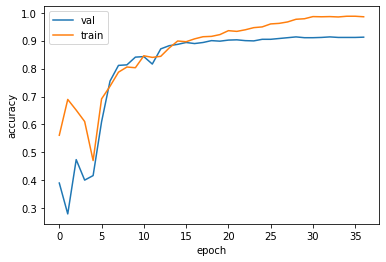

In [32]:
plt.plot(H.history['val_accuracy'], label = "val")
plt.plot(H.history['accuracy'], label = "train")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

In [60]:
'''
prediction
'''
score = model.predict(np.array(X_val))

y_preds_val = np.argmax(score, axis=1)
ytest = np.argmax(y_val, axis=1)
print(accuracy_score(ytest, y_preds_val))
#confusion_matrix(ytest, y_preds)

pd.crosstab(ytest, y_preds_val, rownames=['True'], colnames=['Predicted'], margins=True)

0.9123809523809524


Predicted,0,1,2,All
True,,,,
0,456,52,3,511
1,27,466,5,498
2,1,4,36,41
All,484,522,44,1050


In [61]:
score = model.predict(np.array(X_train_rgb))

y_preds_train = np.argmax(score, axis=1)

print(accuracy_score(y_train.astype(int), y_preds_train))
#confusion_matrix(ytest, y_preds)

pd.crosstab(y_train, y_preds_train, rownames=['True'], colnames=['Predicted'], margins=True)

0.9645714285714285


Predicted,0,1,2,All
True,,,,
0,1204,53,3,1260
1,27,1228,5,1260
2,1,4,100,105
All,1232,1285,108,2625


In [62]:
'''
prediction
'''
# test result
#score = loaded_model.predict(np.array(X_val_rgb))
score = model.predict(np.array(X_test_rgb))
y_preds_test = np.argmax(score, axis=1)

print(accuracy_score(y_test.astype(int), y_preds_test))
#print(confusion_matrix(y_val.ravel(), y_preds))

pd.crosstab(y_test, y_preds_test, rownames=['True'], colnames=['Predicted'], margins=True)

0.9206349206349206


Predicted,0,1,2,All
True,,,,
0,807,73,5,885
1,61,982,15,1058
2,0,1,9,10
All,868,1056,29,1953


In [47]:
pd.DataFrame.from_dict(H.history).head()

,val_loss,val_accuracy,loss,accuracy,lr
0,0.941570,0.390476,0.437692,0.561504,0.00010
1,6.532233,0.280000,0.348688,0.689611,0.00010
2,3.177735,0.474286,0.156040,0.651370,0.00010
3,7.307826,0.400952,0.322027,0.610580,0.00010
4,2.797156,0.417143,0.285939,0.471001,0.00001


In [ ]:
'''
If predictions is good
'''

# score = model.predict(X_train_rgb)
# np.savetxt("./scores/resnet50_scores.csv", score, delimiter=",")

# y_preds = np.argmax(score, axis=1)

# accuracy_score(y_train.ravel(), y_preds)
# confusion_matrix(y_train.ravel(), y_preds)

# pd.crosstab(y_train, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

In [ ]:
#################################
####### begin from here #########
#################################

In [6]:
'''
save model
'''
filename = '46lab1.sav'
#pickle.dump(model, open(filename, 'wb'))
history = "hist_"+filename
#pickle.dump(H, open(history, 'wb'))

In [7]:
'''
load model and training history
'''
#filename = 'cnn_r50_aug_lr1e4_cwa01a012a06a10_catetry_nn64to20_moreaug_.sav'
loaded_model = pickle.load(open(filename, 'rb'))
H = pickle.load(open(history, 'rb'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


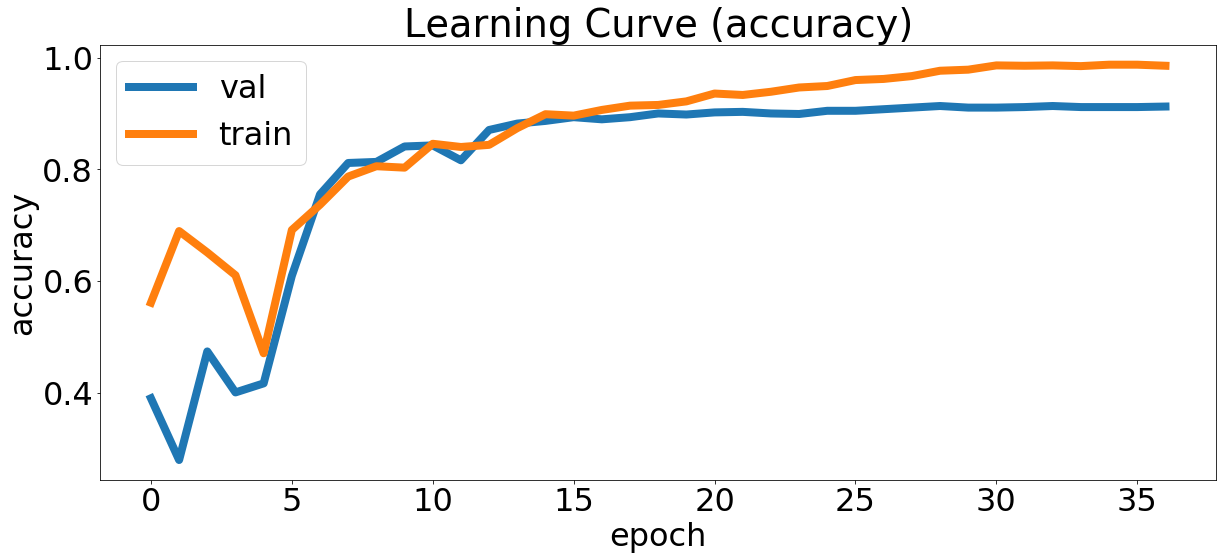

In [39]:
# training history #1
plt.figure(figsize=(20,8))
plt.rc('font', size=32)  
a = plt.plot(H.history['val_accuracy'], label = "val", lw=8)
b = plt.plot(H.history['accuracy'], label = "train", lw=8)
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.title("Learning Curve (accuracy)")
plt.legend()
plt.savefig('training curve.png')

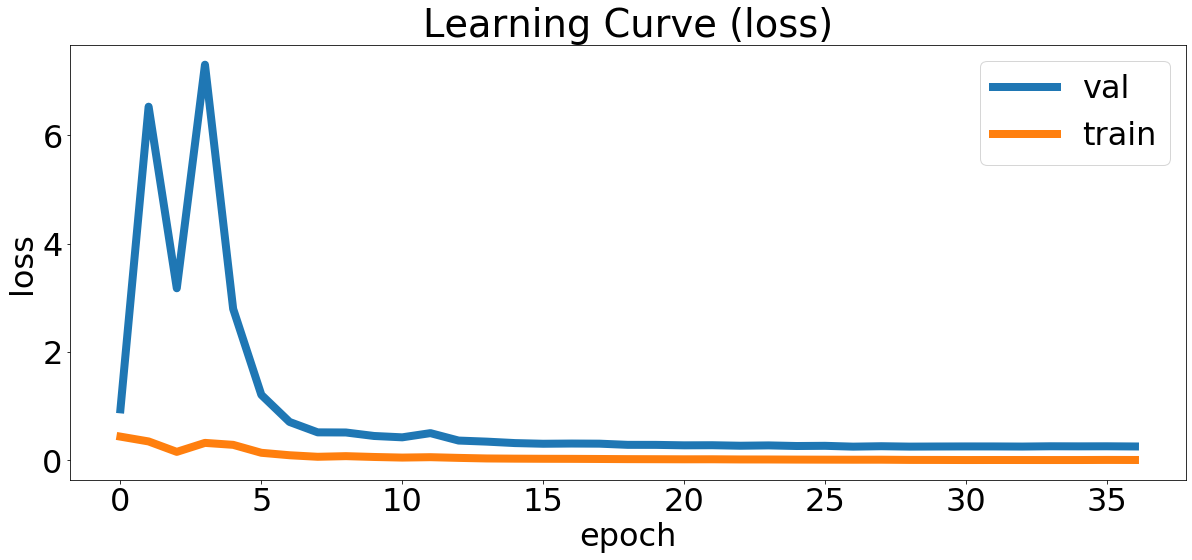

In [38]:
# training history #2
plt.figure(figsize=(20,8))
plt.plot(H.history['val_loss'], label = "val", lw=8)
plt.plot(H.history['loss'], label = "train", lw=8)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Learning Curve (loss)")
plt.legend()
plt.savefig('training error.png')

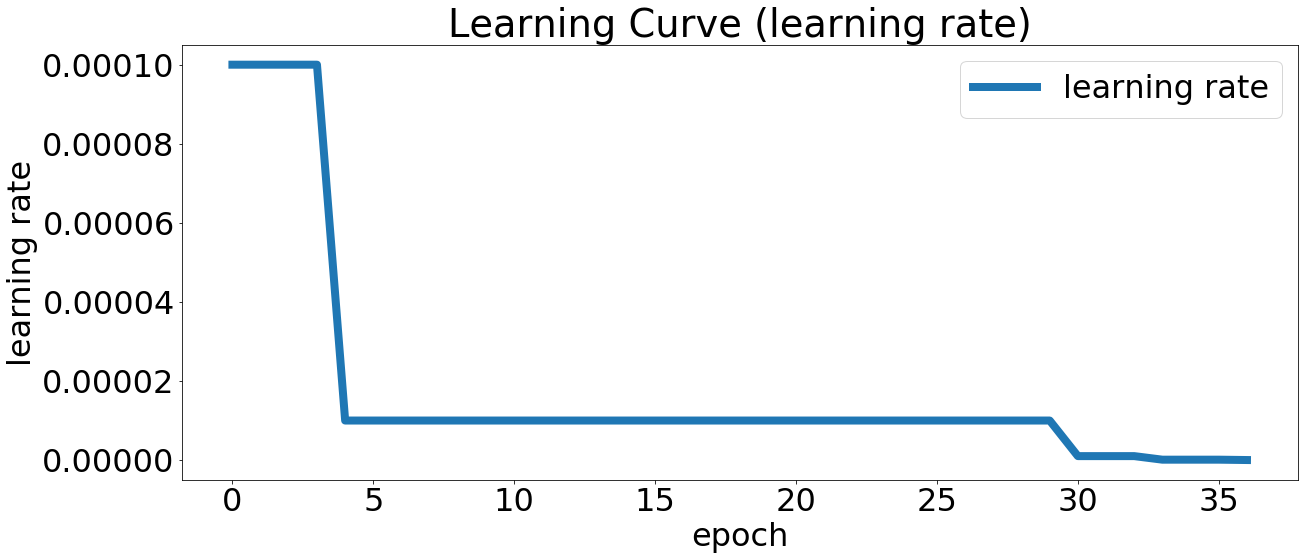

In [37]:
# training history #3
plt.figure(figsize=(20,8))
plt.plot(H.history['lr'], label = "learning rate", lw=8)
plt.ylabel("learning rate")
plt.xlabel("epoch")
plt.title("Learning Curve (learning rate)")
plt.legend()
plt.savefig('learning rate history.png')

# Performance evaluation

In [77]:
def prcurve (y_preds_train, y_probs_train, plotname):
    n_classes = 3
    #Y = label_binarize(y_preds_train, classes=[*range(n_classes)])
    Y = y_preds_train
    y_score = y_probs_train
    # precision recall curve
    precision = dict()
    recall = dict()
    plt.rc('font', size=32)  
    plt.figure(figsize=(12,12))
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_preds_train[:, i],
                                                            y_probs_train[:, i])
        plt.plot(recall[i], precision[i], lw=8, label='class {}'.format(i)  )
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y.ravel(),y_score.ravel())
    #average_precision["micro"] = average_precision_score(y_preds_train, y_probs_train,
    #                                                 average="micro")
    #print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))
    
    plt.xlabel("recall", fontsize = 32)
    plt.ylabel("precision", fontsize = 32)
    plt.legend(loc="best", fontsize = 28)
    plt.title(plotname, fontsize = 40)
    plt.grid()
    plt.savefig(plotname+".png")

In [76]:
def roccurve (y_preds_test, y_probs_test, plotname):
    n_classes = 3
    #Y = label_binarize(y_preds_test, classes=[*range(n_classes)])
    #print(Y.shape)
    #y_score = y_probs_test
    # roc curve
    fpr = dict()
    tpr = dict()
    plt.rc('font', size=32)  
    plt.figure(figsize=(12,12))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_preds_test[:, i],
                                  y_probs_test[:, i])
        plt.plot(fpr[i], tpr[i], lw=8, label='class {}'.format(i))
    
    plt.xlabel("false positive rate", fontsize = 32)
    plt.ylabel("true positive rate", fontsize = 32)
    plt.legend(loc="best", fontsize = 28)
    plt.title(plotname, fontsize = 40)
    plt.grid()
    plt.savefig(plotname+".png")

In [19]:
# Train
y_probs_train = loaded_model.predict(np.array(X_train_rgb)) # predict probability
y_preds_train = np.argmax(y_probs_train, axis=1)  #predict class

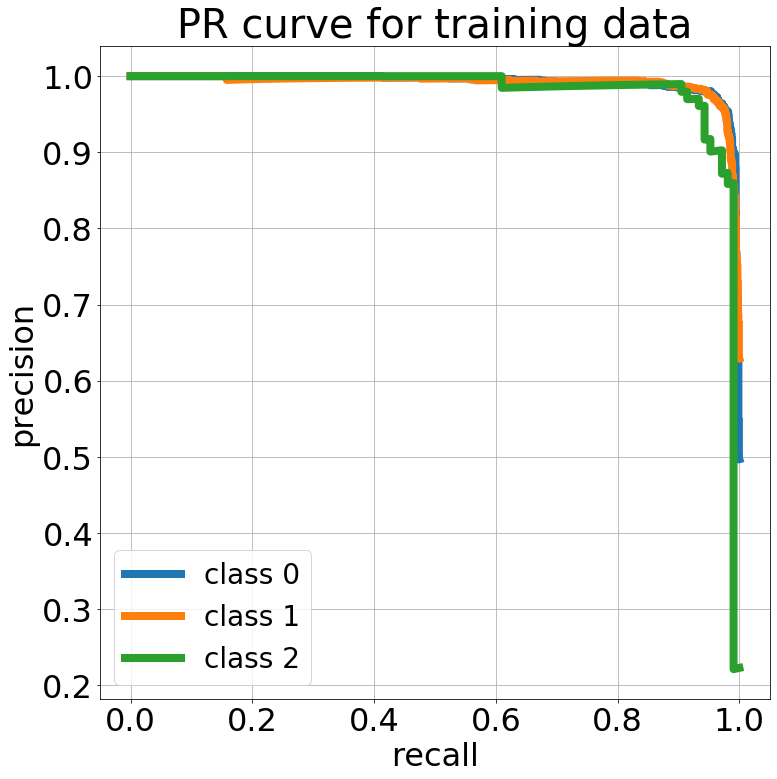

In [78]:
prcurve(y_train_cat, y_probs_train, plotname= 'PR curve for training data')

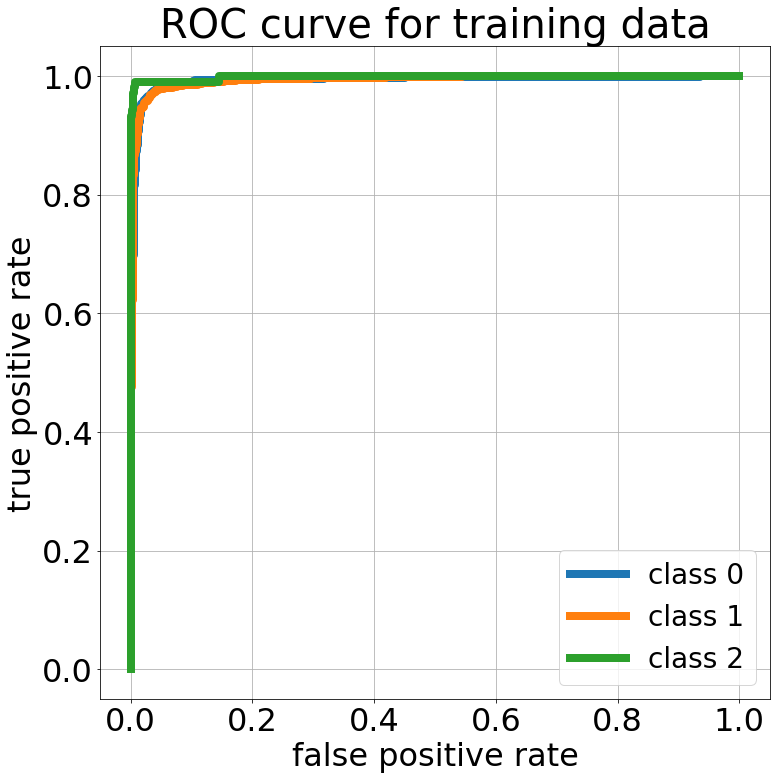

In [79]:
roccurve(y_train_cat, y_probs_train, plotname= 'ROC curve for training data')

In [57]:
# Validation
y_val_eva = np.argmax(y_val, axis = 1)
y_probs_val = loaded_model.predict(np.array(X_val)) # predict probability
y_preds_val = np.argmax(y_probs_val, axis=1) 

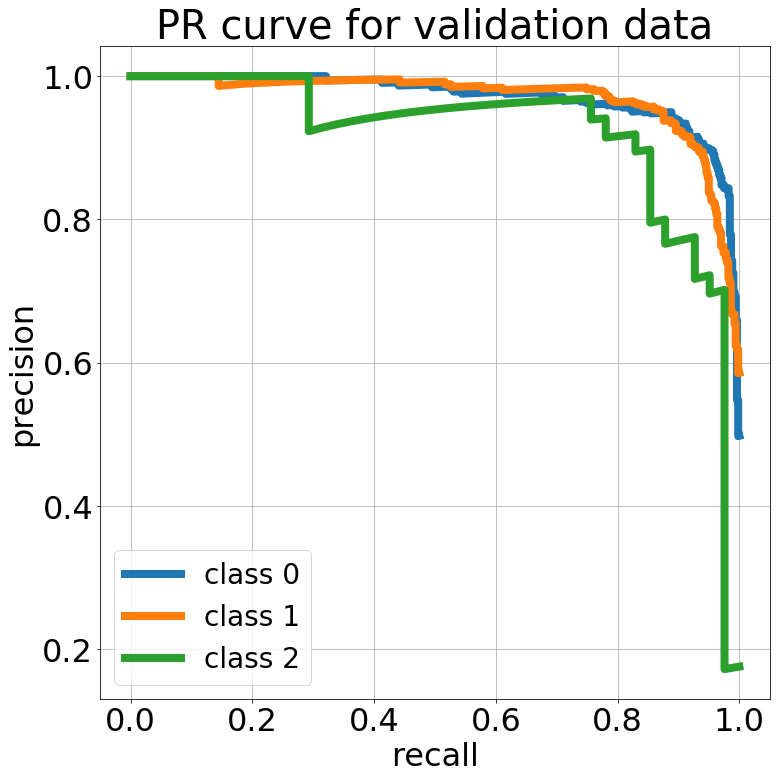

In [80]:
prcurve(y_val, y_probs_val, plotname= 'PR curve for validation data')

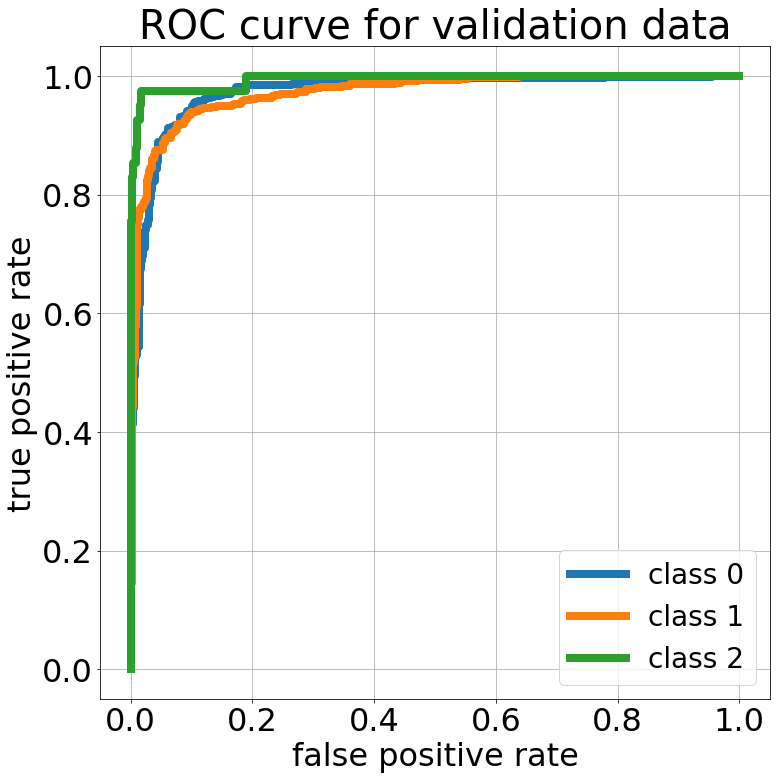

In [81]:
roccurve(y_val, y_probs_val, plotname= 'ROC curve for validation data')

In [60]:
# Test
y_probs_test = loaded_model.predict(np.array(X_test_rgb)) # predict probability
y_preds_test = np.argmax(y_probs_test, axis=1) #predict class

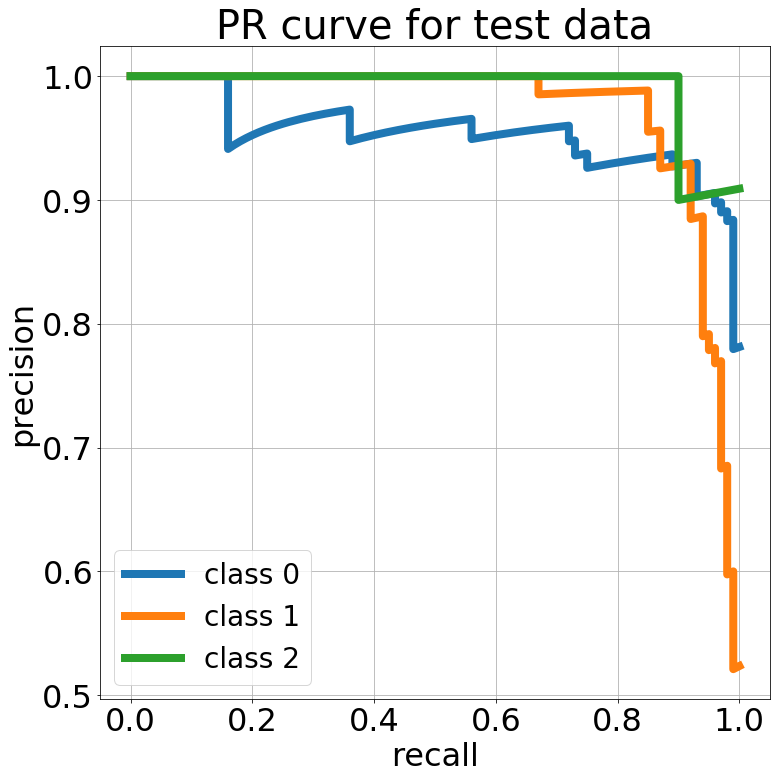

In [82]:
prcurve(y_test_cat, y_probs_test, plotname= 'PR curve for test data')

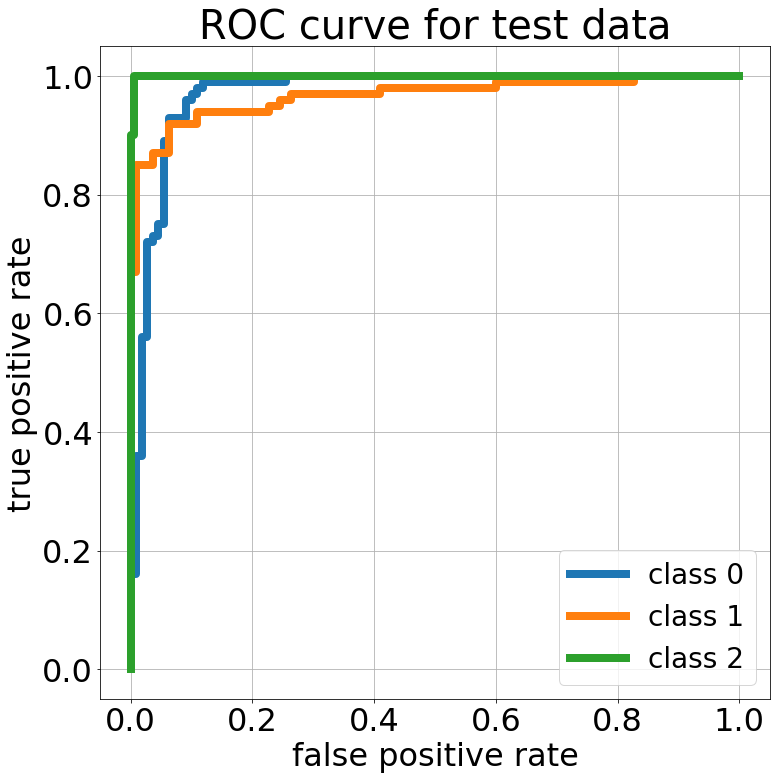

In [83]:
roccurve(y_test_cat, y_probs_test, plotname= 'ROC curve for test data')

In [143]:
def plot_cm(ytrue, ypred, title):
    cm = confusion_matrix(ytrue, ypred)  
    plt.rc('font', size=28) 
    cm_df = pd.DataFrame(cm,
                         index = ['normal','pneumonia','COVID-19'], 
                         columns = ['normal','pneumonia','COVID-19'])

    cm_plot = plt.figure(figsize=(10,10))
    ax = sns.heatmap(cm_df, annot=True, annot_kws={"size": 32}, cmap = 'Blues', fmt='g')
    ax.set_title('Confusion Matrix {0} Data \nAccuracy:{1:.3f}'.format(title, accuracy_score(ytrue, ypred)), fontsize = 40)
    ax.set_ylabel('True label', fontsize = 32)
    ax.set_xlabel('Predicted label', fontsize = 32)
    ax.set_yticklabels(['normal','pneumonia','COVID-19'], rotation=90, va="center") # reset for y ticks

### Train

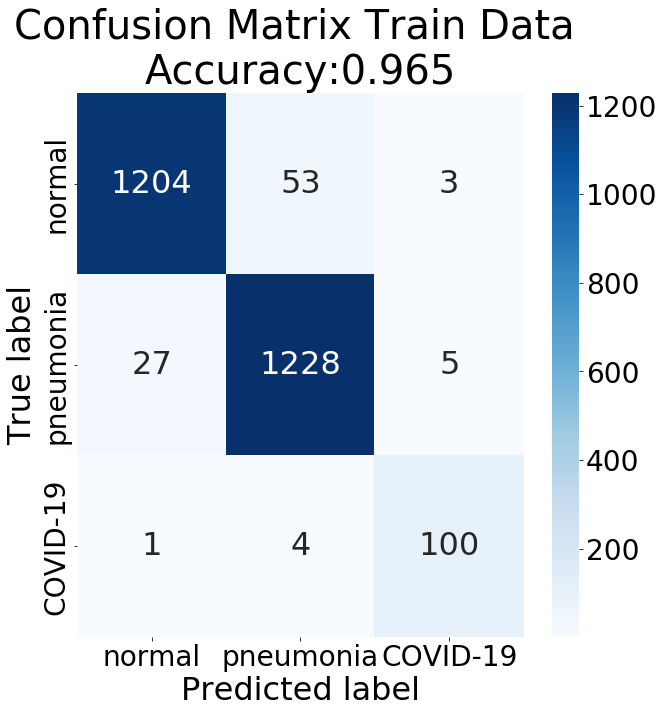

In [144]:
y_train = y_train.astype(int)
plot_cm(y_train, y_preds_train, 'Train')
plt.savefig('training CM.png')

### Validation

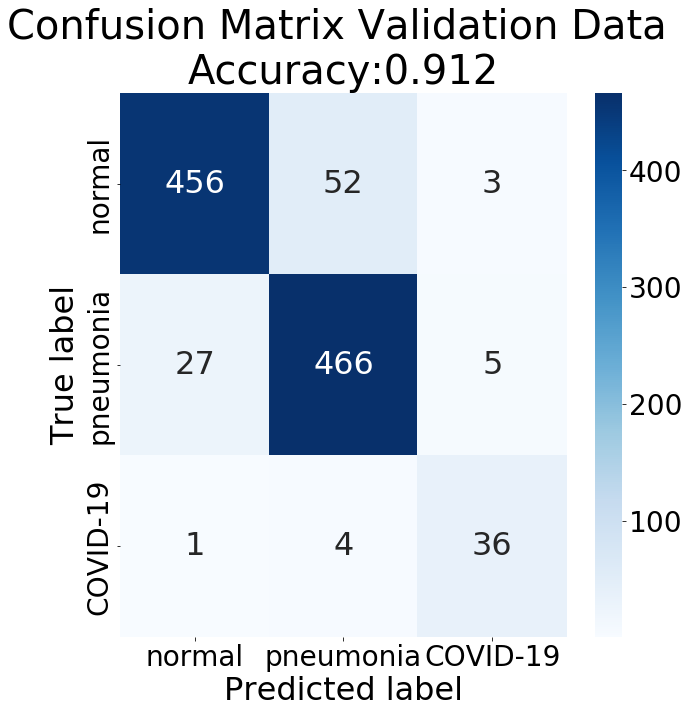

In [145]:
plot_cm(y_val_eva, y_preds_val, 'Validation')
plt.savefig('validation CM.png')

### Test

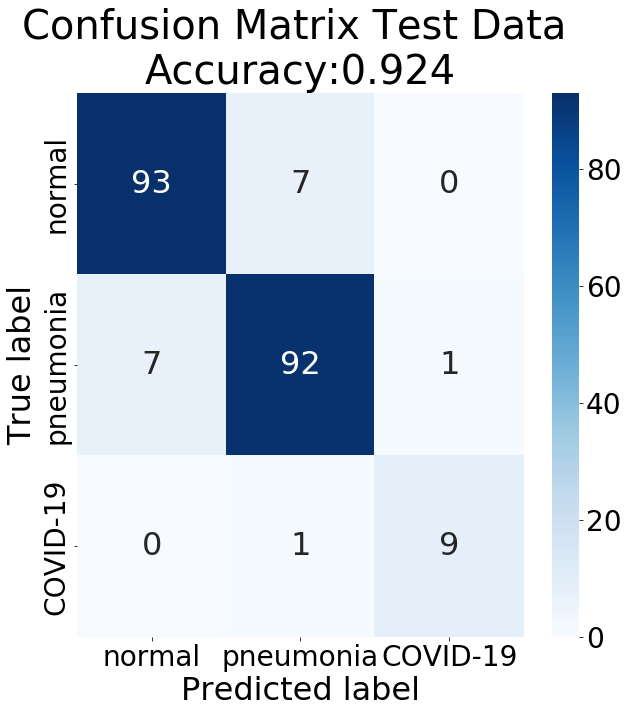

In [146]:
y_test = y_test.astype(int)
plot_cm(y_test, y_preds_test, 'Test')
plt.savefig('test_CM.png')

In [19]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_test, y_preds_test, average = 'weighted'))
print(recall_score(y_test, y_preds_test, average = 'weighted'))
print(accuracy_score(y_test, y_preds_test))

0.9238095238095239
0.9238095238095239
0.9238095238095239


In [20]:
print(precision_score(y_test, y_preds_test, average = 'macro'))
print(recall_score(y_test, y_preds_test, average = 'macro'))
print(accuracy_score(y_test, y_preds_test))

0.9166666666666666
0.9166666666666666
0.9238095238095239


In [21]:
print(precision_score(y_test, y_preds_test, average = 'micro'))
print(recall_score(y_test, y_preds_test, average = 'micro'))
print(accuracy_score(y_test, y_preds_test))

0.9238095238095239
0.9238095238095239
0.9238095238095239


## Check with Data

In [181]:
train_pd = pd.read_csv(dir_train_labels)
train_ids= train_pd.id
test_pd = pd.read_csv(dir_test_labels)
test_ids = test_pd.id

In [24]:
train_ids[(y_train ==0)&(y_preds_train ==0)]  # should be COVID but classified as normal or pneumonia
#train_ids[(y_train!=y_preds_train)&(y_train ==1)]  # should be pneumonia but classified as normal or COVID
#train_ids[(y_train!=y_preds_train)&(y_train ==0)]  # should be normal but classified as pneumonia or COVID

105     7f86fd30-6720-452f-9b42-a82db3cb1d57.png
106     1a388cdd-671b-48a9-9a4c-ca64cc60ef81.png
107     583240d2-445b-4bb3-bb9e-4259263fa763.png
108     dd43fb26-3526-4202-9612-25386e9495bb.png
109     7dd3c24a-f0bf-4a6b-89c0-ccae17748457.png
                          ...                   
1360    2f55650d-f85f-47e7-b6e6-79ad8e3c7c53.png
1361    668c7bea-ca06-4131-9567-33078f889aa0.png
1362    e3d0271b-b53f-4d6b-9e99-57fab7644798.png
1363    f5f2d13e-b5d4-4d1a-ba3c-f4d742b3eca8.png
1364    4bf3d74b-3429-4c77-9f63-108dfcb60f99.png
Name: id, Length: 1204, dtype: object

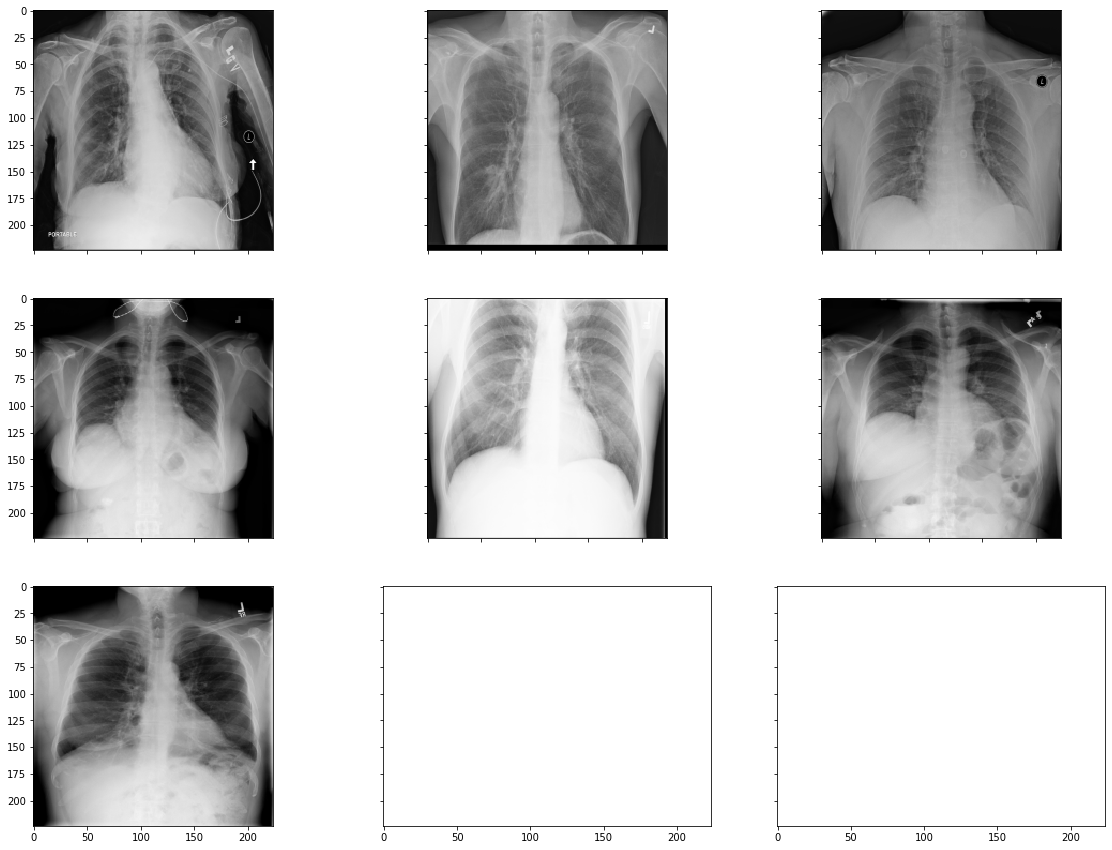

In [25]:
f, axarr = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 15))
for idx, identifier in zip(product([0, 1,2], [0, 1,2]), test_ids[(y_test ==0)&(y_preds_test==1)] ):
    fname     = dir_test_images + identifier
    image     = cv2.imread(fname)
    axarr[idx[0],idx[1]].imshow(image)
plt.show() 

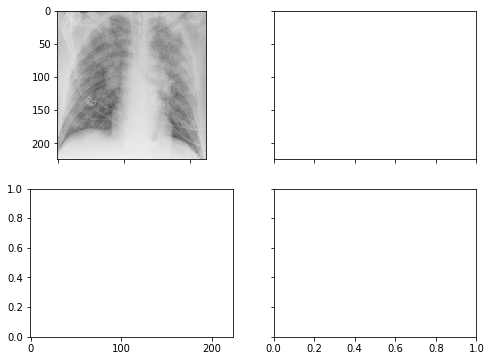

In [26]:
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(8, 6))
for idx, identifier in zip(product([0,1], [0,1]),test_ids[(y_test ==2)&(y_preds_test==1)]):
    fname     = dir_test_images + identifier
    image     = cv2.imread(fname)
    axarr[idx[0],idx[1]].imshow(image)
plt.show()

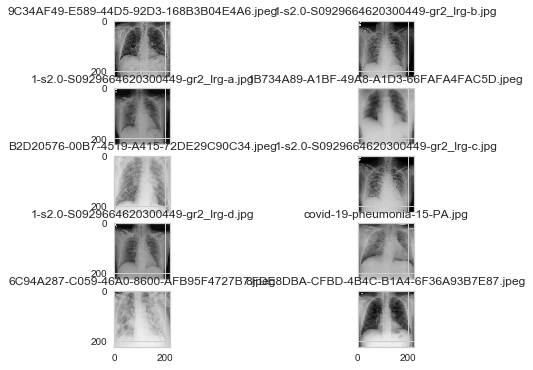

In [188]:
f, axarr = plt.subplots(5, 2, sharex='col', sharey='row', figsize=(8, 6))
for idx, identifier in zip(product([0,1,2,3,4], [0,1]),test_ids[(y_test ==2)]):
    fname     = dir_test_images + identifier
    image     = cv2.imread(fname)
    axarr[idx[0],idx[1]].imshow(image)
    axarr[idx[0],idx[1]].set_title(identifier)
plt.show()

In [216]:
np.max(y_probs_test[y_test[(y_test==0)&(y_preds_test==1)],0])

0.9995621

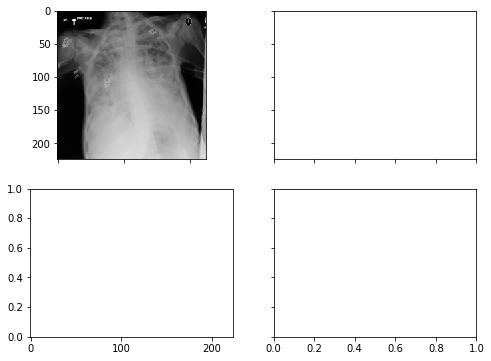

In [27]:
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(8, 6))
for idx, identifier in zip(product([0,1], [0,1]),test_ids[(y_test ==1)&(y_preds_test==2)]):
    fname     = dir_test_images + identifier
    image     = cv2.imread(fname)
    axarr[idx[0],idx[1]].imshow(image)
plt.show()

In [213]:
y_preds_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1], dtype=int64)

In [211]:
print(test_ids[(y_test ==1)])

100             bd8facb9-dce0-4048-8249-e6078b28e1b7.png
101             4dbc44ca-694a-4814-9a24-bc60c8d8d611.png
102             3f504abe-2133-4e09-98af-743cdea486f9.png
103             af169d21-1c39-445e-82d8-5035182a3a8c.png
104             fcd159f4-21d3-4169-a94b-95a2b5ccddcb.png
                             ...                        
195             a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png
196             41bf2042-53a2-44a8-9a29-55e643af5ac0.png
207    streptococcus-pneumoniae-pneumonia-temporal-ev...
208    streptococcus-pneumoniae-pneumonia-temporal-ev...
209    streptococcus-pneumoniae-pneumonia-temporal-ev...
Name: id, Length: 100, dtype: object


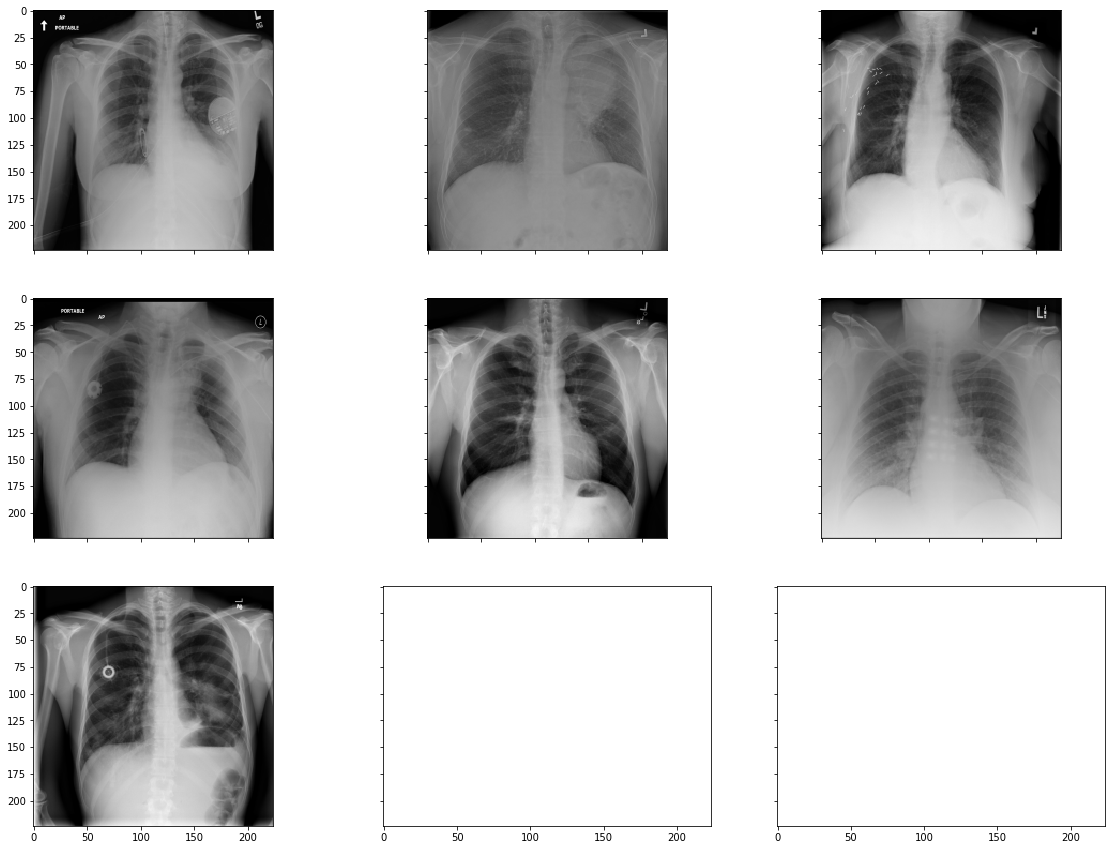

In [28]:
f, axarr = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 15))
for idx, identifier in zip(product([0, 1,2], [0, 1,2]),test_ids[(y_test ==1)&(y_preds_test==0)]):
    fname     = dir_test_images + identifier
    image     = cv2.imread(fname)
    axarr[idx[0],idx[1]].imshow(image)
plt.show()

In [193]:
test_ids[(test_ids =="0b8e3d9e-0bcd-41a3-b788-0175c43b2624.png")]

Series([], Name: id, dtype: object)

In [11]:
# validation perforemance
score = loaded_model.predict(np.array(X_val))

y_preds = np.argmax(score, axis=1)
ytest = np.argmax(y_val, axis=1)
print(accuracy_score(ytest, y_preds))
#confusion_matrix(ytest, y_preds)

pd.crosstab(ytest, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

0.9004424778761062


Predicted,0,1,2,All
True,,,,
0,190,17,2,209
1,16,184,7,207
2,0,3,33,36
All,206,204,42,452


In [12]:
# wholee training dataset performance
score = loaded_model.predict(np.array(X_train_rgb))

y_preds = np.argmax(score, axis=1)

print(accuracy_score(y_train.astype(int), y_preds))
#confusion_matrix(ytest, y_preds)

pd.crosstab(y_train, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

0.9700996677740864


Predicted,0,1,2,All
True,,,,
0,681,17,2,700
1,16,677,7,700
2,0,3,102,105
All,697,697,111,1505


In [13]:
'''
prediction
'''
# test result
#score = loaded_model.predict(np.array(X_val_rgb))
score = loaded_model.predict(np.array(X_test_rgb))
y_preds = np.argmax(score, axis=1)

print(accuracy_score(y_test.astype(int), y_preds))
#print(confusion_matrix(y_val.ravel(), y_preds))

pd.crosstab(y_test, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

0.8975934459805428


Predicted,0,1,2,All
True,,,,
0,786,89,10,885
1,82,959,17,1058
2,1,1,8,10
All,869,1049,35,1953


In [14]:
loaded_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________